# Lego Reinforcement Learning

### Key Concepts:
* RL algorithms are modular
* Each building block can be removed or added to the system without manually rewriting pipeline

In [1]:
from LegoRL import *

In [2]:
import gym
env = gym.make('CartPole-v0').unwrapped

In [3]:
import torch.nn as nn
CartpoleNN = lambda input_size, output_size: nn.Sequential(
                nn.Linear(input_size, 20),
                nn.ReLU(),
                nn.Linear(20, output_size),
                nn.ReLU()
)

## Basic principles:

* **RLmodule** is a building block for algorithms.
* **Composed** is a building block that incorporates several building blocks.
* **System** allows all building blocks to communicate, stores logs, information about environment, controls saving-loading, etc.

For example, ***Runner*** is a building block that each step performs one step in the environment. \
There is a hyperparameter, *policy*, which is random behavior by default.

In [4]:
# create building block
agent = Runner()

In [5]:
# create system with our agent
# this is required to connect all modules together and add environment.
system = System(agent, env)

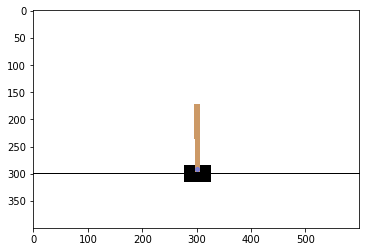

..\c10/core/TensorImpl.h:864: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable.


In [6]:
# Runner block also has special method to play one game in the environment and record everything
rollout = agent.play(render=True)

In [7]:
rollout

Rollout of length 14 of size 1. Additional information stored: {'id', 'frames'}

In [8]:
rollout.keys()

dict_keys(['all_states', 'id', 'actions', 'rewards', 'discounts', 'frames'])

# Visualization

**Composed** allows us to unite several blocks in one. For example, we can use it to have not only ***Runner***, but also a ***Visualizer*** in our system.

One iteration for **Composed** module is just calling _iteration_ method from all incorporated modules. \
*timer* parameter for visualizer tells system to call it only once in 100 frames.

In [9]:
agent = Composed(
    Runner(),
    Visualizer(timer=100)
)

In [10]:
system = System(agent, env)

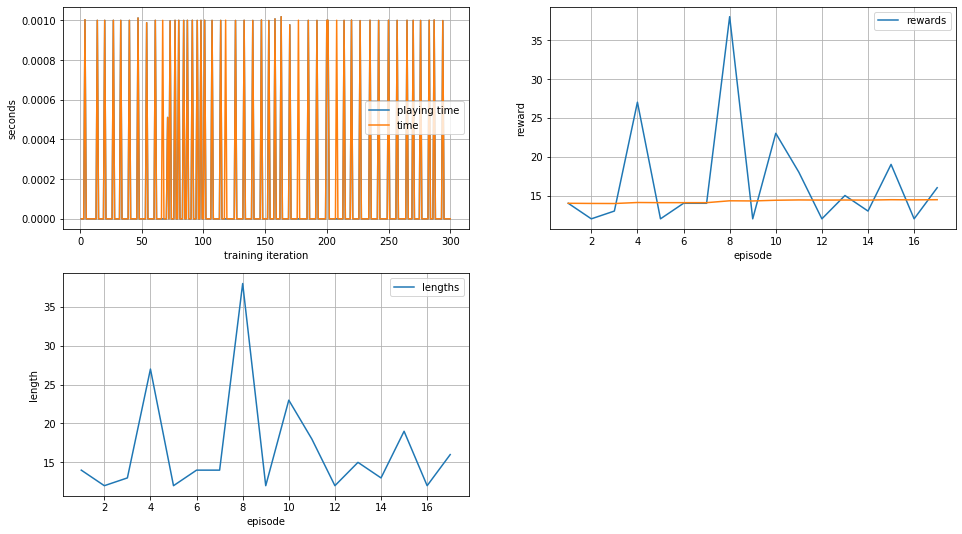

In [11]:
# run 300 iterations
system.run(300)

System also stores all logs from session.

In [12]:
system.logger.keys()

dict_keys(['playing time', 'time', 'rewards', 'lengths', 'episode ends'])

In [13]:
system.logger['rewards']

[14.0,
 12.0,
 13.0,
 27.0,
 12.0,
 14.0,
 14.0,
 38.0,
 12.0,
 23.0,
 18.0,
 12.0,
 15.0,
 13.0,
 19.0,
 12.0,
 16.0]

# DQN

Now, DQN in this paradigm consists of many, many blocks...

In [14]:
visualizer      = Visualizer()
backbone        = Backbone(CartpoleNN, embedding_size=20)
q_head          = QualityHead(backbone=backbone)
policy          = eGreedy(greedy_policy=q_head)
runner          = Runner(policy=policy)  
replay          = ReplayBuffer(runner=runner)
sampler         = Sampler(replay=replay)
target_backbone = Frozen(Backbone)(source=backbone)
target_net      = Frozen(QualityHead)(source=q_head, backbone=target_backbone)
target          = OneStep(evaluator=target_net)
critic_loss     = CriticLoss(sampler=sampler, critic=q_head, target=target)
trainer         = Trainer(transformations=[backbone, q_head], losses=[critic_loss])

Why so many? It is important to split simple algorithm like DQN to many parts in order to reuse this code in modifications and other algorithms.

Let's unite them in one **Composed** module and look what each of them is doing:

In [15]:
agent = Composed(visualizer, backbone, q_head, policy, runner, replay, sampler, target_backbone, target_net, target, critic_loss, trainer)

In [16]:
agent

<visualizer>: Plots logs every 100 iteration
<backbone>: Feature extractor network
<qualityhead>: Head, connected to <backbone>, modeling Quality
<egreedy>: Acts randomly with eps-probability, otherwise calls <qualityhead>
<runner>: Makes one step in 1 parallel environments each 1 iteration using <egreedy>
<replaybuffer>: Stores observations from <runner>
<sampler>: Samples mini-batches from <replaybuffer>
<frozenbackbone>: Copy of <backbone>, updated each 100 iteration
<frozenqualityhead>: Copy of <qualityhead>, updated each 100 iteration
<onestep>: Calculates one-step TD target using <frozenqualityhead> as next state estimator
<criticloss>: Calculates TD loss for <qualityhead> using <onestep> as target calculator and data from <sampler>
<trainer>: Trains <backbone>, <qualityhead> using following losses: <criticloss>

There are several hints why these modules are separated:
* we might want to connect another head to **backbone** of network, like actor head for policy gradient algorithms or some world dynamics decoder.
* we might want to use another Q-function representation like in Categorical DQN or Quantile Regression DQN
* we might want to change or turn off **eGreedy** exploration strategy
* we might want to change **replayBuffer** and store $N$-step transitions like in Multi-Step DQN.
* we might want to change **sampler** strategy by using, for example, prioritized replay.
* we might want to use this **replayBuffer** to sample mini-batches for another losses, heads or even optimization procedures.
* we might want to turn on or off target network heuristic (**frozen** modules), or use it as policy (because it can also generate Q function...).
* we might want to calculate **target** like in Double DQN
* finally, **trainer** is the module that on each *iteration* calls all provided loss functions (in DQN it is just the **critic loss** originating from Bellman equations) and performs one step of gradient optimization (it also accepts optimizer parameters; by default, it is Adam)

In [17]:
# initialization: we have some logs about network initialization.
system = System(agent, env)

Initializing <backbone>:
  Input shape is torch.Size([4])
  Output shape is torch.Size([20])
Initializing <qualityhead>:
  Input shape is torch.Size([20])
  Output shape is torch.Size([2])


In [18]:
# run one step in debug mode
system.run(debug=True)

runner: plays one step.
  qualityhead: received act query.
    backbone: forward pass output for current computed.
    qualityhead: forward pass output for current computed.
  egreedy: mixing some exploration in...
runner: returns same sample.
replaybuffer: adds new observations from runner.
trainer: initiates loss computation.
  sampler: cold start regime: batch is not sampled.
  criticloss: no batch is found, loss is None.
trainer: loss is None; no optimization step is performed.


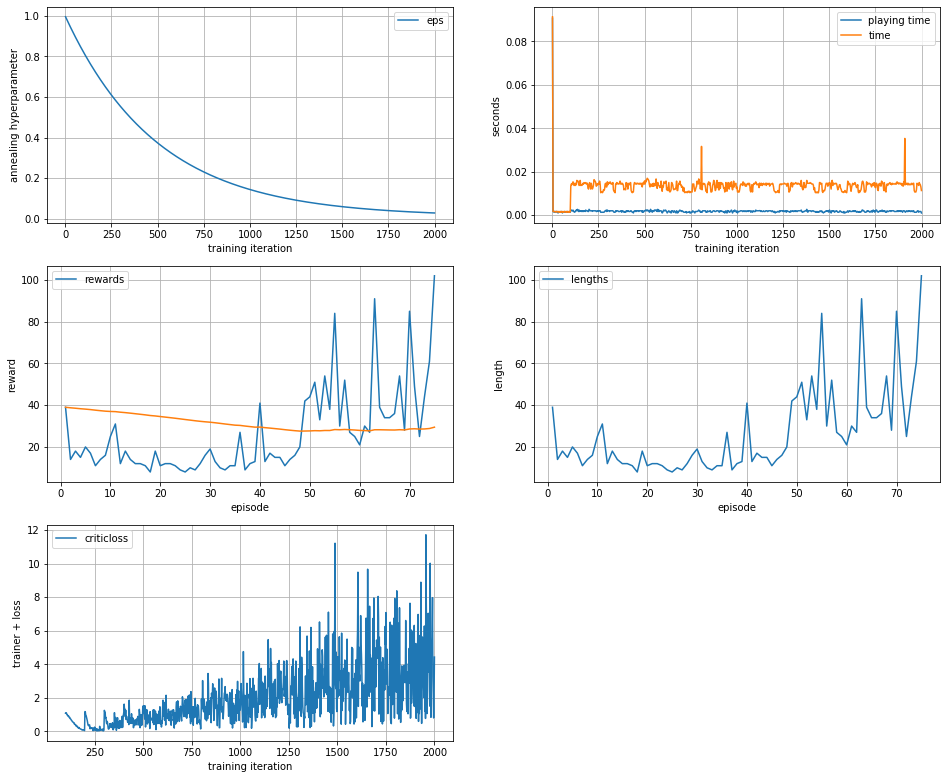

In [19]:
# run 2000 iterations
system.run(2000)

In [20]:
# store model
system.save("models/cartpole_dqn")

# Composed modules

Why is this convinient? Convinience comes from possibility of uniting modules in more advanced **Composed** modules.

Our goal for today will be ___Twin DQN___ algorithm, where two DQNs are trained in parallel and used as next state evaluators for each other.

Obviously, we do not want to list all modules for more complicated systems. So, let's unite some of them in one DQN **Composed** module:

In [21]:
def DQN(NN, replay, target_critic=None):
    sampler  = Sampler(replay=replay)
    backbone = Backbone(NN, embedding_size=20)
    q_head   = QualityHead(backbone=backbone)
    double   = Double(selector=q_head, evaluator=target_critic)
    target   = OneStep(evaluator=double)
    dqn_loss = CriticLoss(sampler=sampler, critic=q_head, target=target)
    trainer  = Trainer(transformations=[backbone, q_head], losses=[dqn_loss])
    
    return Composed(sampler, backbone, q_head, double, target, dqn_loss, trainer)

Here there is a problem: DQN must have a link to ***replay buffer***, which takes data from ***Runner***, which requires a policy... which requires DQN. You got the idea.

So here is some fancy _referencing via names_ that we support.

In [22]:
agent = Composed(
    visualizer      = Visualizer(),
    runner          = Runner(policy="policy"),
    replay          = ReplayBuffer(runner="runner"),
    dqn             = DQN(CartpoleNN, replay="replay", target_critic="target"),
    target_backbone = Frozen(Backbone)(source="dqn.backbone"),
    target          = Frozen(QualityHead)(source="dqn.qualityhead", backbone="target_backbone"),
    policy          = eGreedy(greedy_policy="dqn.qualityhead"),
)

What happened here? Let's look!

In [23]:
agent

<visualizer>: Plots logs every 100 iteration
<runner>: Makes one step in 1 parallel environments each 1 iteration using <policy>
<replay>: Stores observations from <runner>
<dqn>:
    <sampler>: Samples mini-batches from <replay>
    <backbone>: Feature extractor network
    <qualityhead>: Head, connected to <backbone>, modeling Quality
    <double>: Evaluates value as Q from <target> of actions selected by <qualityhead>
    <onestep>: Calculates one-step TD target using <double> as next state estimator
    <criticloss>: Calculates TD loss for <qualityhead> using <onestep> as target calculator and data from <sampler>
    <trainer>: Trains <backbone>, <qualityhead> using following losses: <criticloss>
    
<target_backbone>: Copy of <dqn.backbone>, updated each 100 iteration
<target>: Copy of <dqn.qualityhead>, updated each 100 iteration
<policy>: Acts randomly with eps-probability, otherwise calls <dqn.qualityhead>

We can dive a bit inside by navigating through the *modules tree*:

In [24]:
agent['dqn']

<sampler>: Samples mini-batches from <replay>
<backbone>: Feature extractor network
<qualityhead>: Head, connected to <backbone>, modeling Quality
<double>: Evaluates value as Q from <target> of actions selected by <qualityhead>
<onestep>: Calculates one-step TD target using <double> as next state estimator
<criticloss>: Calculates TD loss for <qualityhead> using <onestep> as target calculator and data from <sampler>
<trainer>: Trains <backbone>, <qualityhead> using following losses: <criticloss>

In [25]:
agent['dqn']['sampler'].__dict__

{'timer': 1,
 'frozen': False,
 '_active': <function LegoRL.core.RLmodule.RLmodule.__init__.<locals>.<lambda>()>,
 '_initialized': False,
 '_performed': False,
 'replay': Reference at RLmodule named replay; it will be changed to direct link after system initialization,
 'batch_size': 32,
 'cold_start': 100,
 '_sample': None,
 'name': 'sampler'}

For **Sampler** module, there are some hyperparamethers (*frozen*=True means module does nothing each iteration; *timer* means it will only work each $t$-th iteration; *batch_size* and *cold_start* are hyperparameters)...

Also, there is an interesting field *_sample*, which is where the module stores sampled mini-batch. In our paradigm, sampler does not know what modules in the system require this mini-batch. Even if he is provided with the list of links (I've tried this option...), then triggered modules might not have all necessary information at the moment when the batch is sampled. Instead of some complicated synchronization mechanism, the idea is the following: **Sampler** stores the batch in his *_sample* field, and all modules requiring it *reference* **Sampler** and look for this property.

Similarly **Sampler** communicates with **ReplayBuffer** by storing a direct link to it. Unfortunately, we did not have a direct link to **ReplayBuffer**, so instead there is a *Reference*.  

In [26]:
agent['dqn']['sampler'].replay

Reference at RLmodule named replay; it will be changed to direct link after system initialization

Let's initialize our **System**!

In [27]:
system = System(agent, env)

Initializing <dqn.backbone>:
  Input shape is torch.Size([4])
  Output shape is torch.Size([20])
Initializing <dqn.qualityhead>:
  Input shape is torch.Size([20])
  Output shape is torch.Size([2])


Now, let's look what happened:

In [28]:
agent['dqn']['sampler'].replay

Stores observations from <runner>

In [29]:
type(agent['dqn']['sampler'].replay)

LegoRL.buffers.replayBuffer.ReplayBuffer

In [30]:
agent['dqn']['sampler'].replay is agent['replay']

True

We can use such referencing for convinient initialization of our agents now!

# Twin DQN

In [31]:
DQN = lambda NN, replay, target_critic=None: Composed(
    sampler  = Sampler(replay=replay),
    backbone = Backbone(NN, embedding_size=20),
    q_head   = QualityHead(backbone="backbone"),
    double   = Double(selector="q_head", evaluator=target_critic),
    target   = OneStep(evaluator="double"),
    dqn_loss = CriticLoss(sampler="sampler", critic='q_head', target="target"),
    trainer  = Trainer(transformations=["backbone", "q_head"], losses=["dqn_loss"])
)

In [32]:
agent = Composed(
    visualizer = Visualizer(),
    runner     = Runner(policy="policy"),
    replay     = ReplayBuffer(runner="runner"),
    dqn        = DQN(CartpoleNN, replay="replay", target_critic="dqn2.q_head"),
    dqn2       = DQN(CartpoleNN, replay="replay", target_critic="dqn.q_head"),
    policy     = eGreedy(greedy_policy="dqn.q_head"),
)

Now we have TWO **Backbone**s in our system, so there will be TWO logs about connections from **System** during initialization:

In [33]:
system = System(agent, env)

Initializing <dqn.backbone>:
  Input shape is torch.Size([4])
  Output shape is torch.Size([20])
Initializing <dqn.q_head>:
  Input shape is torch.Size([20])
  Output shape is torch.Size([2])
Initializing <dqn2.backbone>:
  Input shape is torch.Size([4])
  Output shape is torch.Size([20])
Initializing <dqn2.q_head>:
  Input shape is torch.Size([20])
  Output shape is torch.Size([2])


In [34]:
# look at list of all modules with their description
agent

<visualizer>: Plots logs every 100 iteration
<runner>: Makes one step in 1 parallel environments each 1 iteration using <policy>
<replay>: Stores observations from <runner>
<dqn>:
    <sampler>: Samples mini-batches from <replay>
    <backbone>: Feature extractor network
    <q_head>: Head, connected to <dqn.backbone>, modeling Quality
    <double>: Evaluates value as Q from <dqn2.q_head> of actions selected by <dqn.q_head>
    <target>: Calculates one-step TD target using <dqn.double> as next state estimator
    <dqn_loss>: Calculates TD loss for <dqn.q_head> using <dqn.target> as target calculator and data from <dqn.sampler>
    <trainer>: Trains <dqn.backbone>, <dqn.q_head> using following losses: <dqn.dqn_loss>
    
<dqn2>:
    <sampler>: Samples mini-batches from <replay>
    <backbone>: Feature extractor network
    <q_head>: Head, connected to <dqn2.backbone>, modeling Quality
    <double>: Evaluates value as Q from <dqn.q_head> of actions selected by <dqn2.q_head>
    <target>:

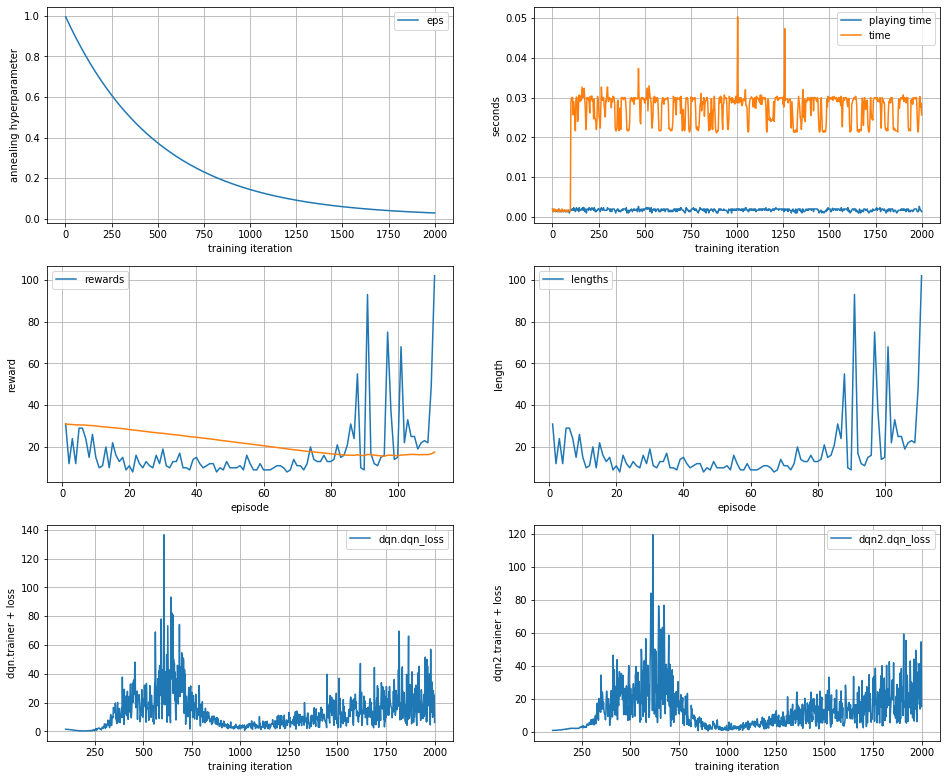

In [35]:
# train for 2000 iterations
system.run(2000)

In [36]:
# play one game and sum rewards
rollout = agent['runner'].play()
sum(rollout.rewards.numpy)

array([43.], dtype=float32)

In [37]:
rollout

Rollout of length 43 of size 1. Additional information stored: {'id', 'frames', 'dqn.q_head output for current', 'dqn.backbone output for current'}

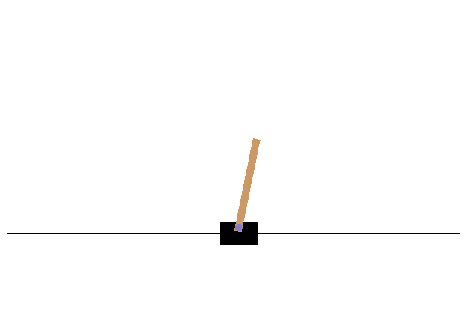

In [38]:
# displaying using HTML
show_animation(rollout['frames'])

In [39]:
# saving
system.save("models/twindqn")

# Fancy stuff with *timer*

Suppose we now want to have fewer interactions with environment. All we need to do is change **Runner**'s *timer*:

In [40]:
agent['runner'].timer = 30

In [41]:
agent['runner']

Makes one step in 1 parallel environments each 30 iteration using <policy>

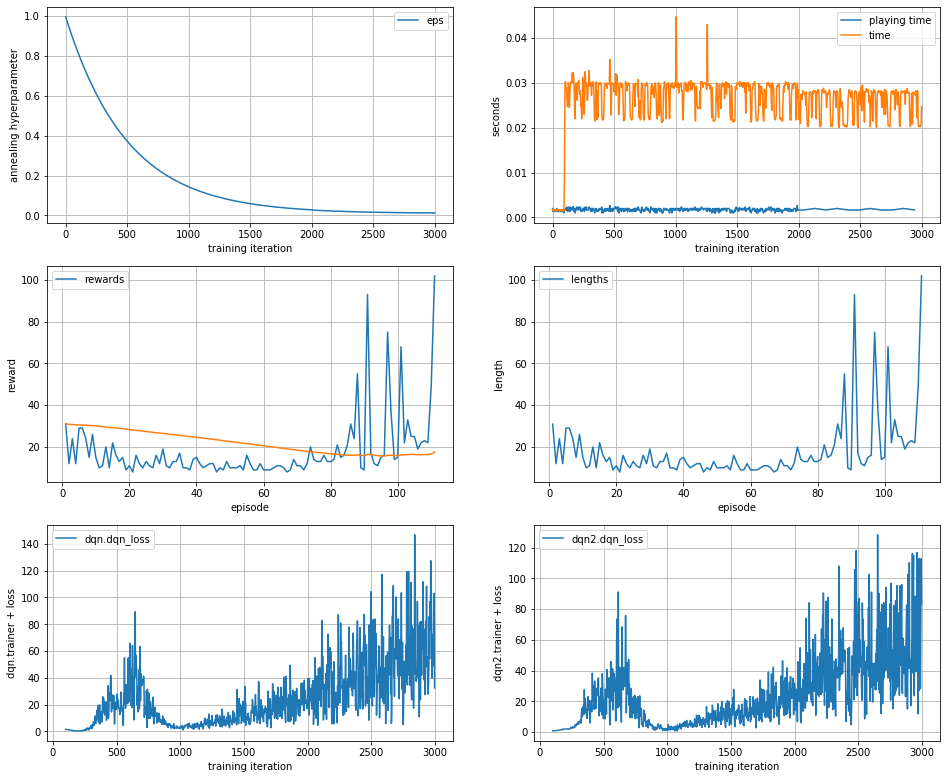

In [42]:
# train for 1000 more iterations
# (almost) no new rewards appear on rewards plot from Runner
# "playing time" plot also has much less points now
system.run(1000)

In [43]:
# we stored a bit more than 2000 transitions
len(agent['replay'])

2034

We can even turn **Runner** off. Its *iteration* method will not be called.

In [44]:
agent['runner'].frozen = True

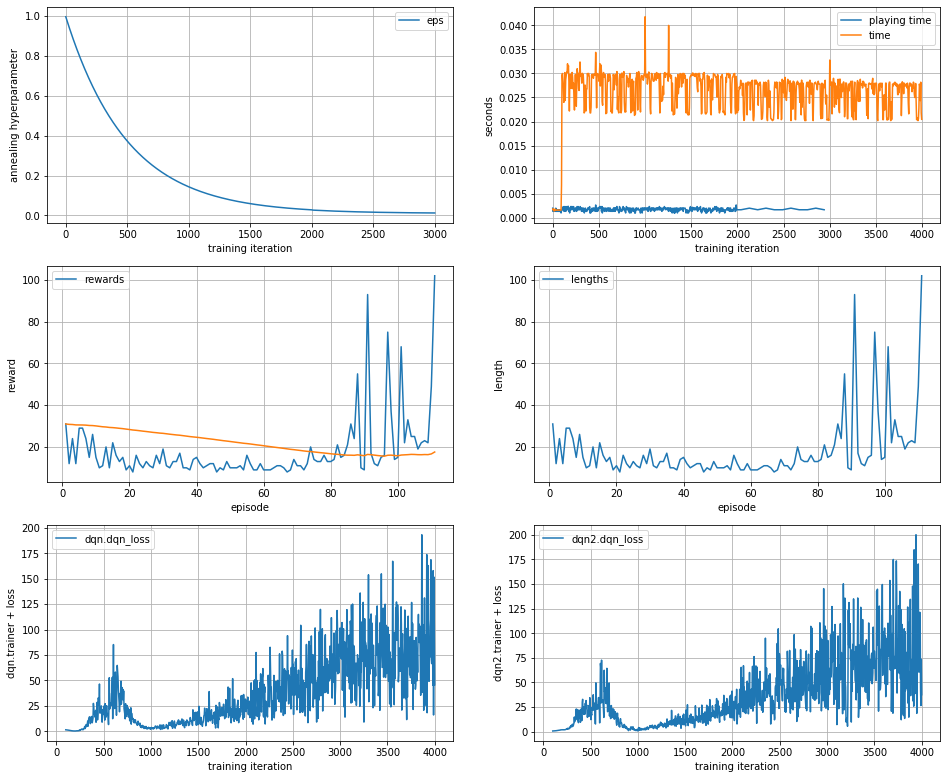

In [45]:
# train for 1000 more iterations
# no more new rewards, no more points on "playing time" plot
system.run(1000)

In [46]:
# no new observations!
len(agent['replay'])

2034

# Looking inside batch

One more important detail.

In [47]:
# last sampled batch is stored here
batch = agent['dqn']['sampler'].sample()

In [48]:
batch.keys()

dict_keys(['states', 'actions', 'rewards', 'next_states', 'discounts', 'dqn.backbone output for current', 'dqn.q_head output for current', 'dqn.backbone output for next', 'dqn.q_head output for next', 'dqn2.backbone output for next', 'dqn2.q_head output for next', 'dqn.dqn_loss loss'])

As you can see, beside obvious properties (s, a, r, s', done, discounts), there are some more. \
It is a ***cache*** for our networks. It means that if the same **Backbone** or **qHead** is called again on this batch, this cache will be reused.

In [49]:
Q = batch['dqn.q_head output for current']
Q

Q-function for 2 actions

In [50]:
# shape is (32 x 2) which is (batch_size x num_actions)
# this tensor is also differentiable
Q.tensor.shape

torch.Size([32, 2])

In [51]:
# We use PyTorch 1.3.0 (unstable) Named Tensors 
# to denote all dimensions in representation
Q.tensor.names

('batch', 'actions')

What cache allows us to do? **Do not think about the order of modules execution.** In A2C, policy loss uses outputs of the network because in pipeline critic loss is computed before it; in prioritized replay, calculated loss is used as priorities for sampler. Now all networks outputs will be cached and we can think about modules' logic other than data transmission between them.

# Pipeline

It is better to define env as function, returning function, to be able to run OpenAI VecEnvs.

In [52]:
from LegoRL import *

In [53]:
import gym
def make_env():
    def _thunk():
        return gym.make('CartPole-v0').unwrapped
    return _thunk

After checking the environment, define PyTorch network.

In [54]:
import torch.nn as nn
CartpoleNN = lambda input_size, output_size: nn.Sequential(
                nn.Linear(input_size, 20),
                nn.ReLU(),
                nn.Linear(20, output_size),
                nn.ReLU()
)

After defining the network, it is good to construct the model, orginizing different blocks in **Composed** RLmodules:

In [55]:
DoubleDQN = Composed(
    backbone = Backbone(CartpoleNN, embedding_size=20),
    q_head   = QualityHead(backbone="backbone"),
    frozen_b = Frozen(Backbone)(source="backbone"),
    frozen   = Frozen(QualityHead)(source="q_head", backbone="frozen_b"),
    double   = Double(selector="q_head", evaluator="frozen"),
    target   = OneStep(evaluator="double"),
    dqn_loss = CriticLoss(sampler="sampler", critic='q_head', target="target"),
    trainer  = Trainer(transformations=["backbone", "q_head"], losses=["dqn_loss"])
)

In [56]:
Model = Composed(
    runner     = Runner(policy="policy"),
    replay     = ReplayBuffer(runner="runner"),
    sampler    = Sampler(replay="replay"),
    dqn        = DoubleDQN,
    policy     = eGreedy(greedy_policy="dqn.q_head"),
)

Add visualizer and **Player** to evaluate some policy each *timer*-s iteration.

In [57]:
agent = Composed(
    visualizer = Visualizer(),
    player     = Player(timer=100, policy="model.dqn.q_head", record_timer=1000, records_file_name="videos/cartpole_dqn"),
    model      = Model   
)

Define **System**'s parameters to automatically save model each *save_timer*-s iteration.

In [58]:
system = System(make_env=make_env, agent=agent, save_timer=500, file_name="models/cartpole_dqn")

Initializing <model.dqn.backbone>:
  Input shape is torch.Size([4])
  Output shape is torch.Size([20])
Initializing <model.dqn.q_head>:
  Input shape is torch.Size([20])
  Output shape is torch.Size([2])


Run ;)

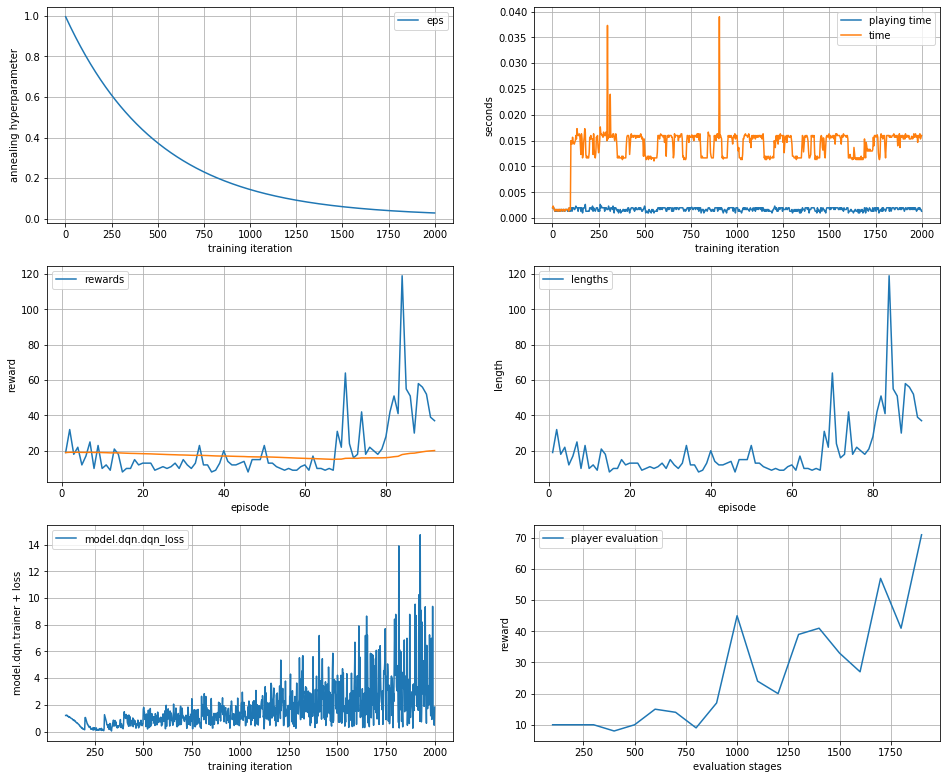

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [59]:
system.run(2000)

To continue training after reloading notebook, simply load the **System**.

In [60]:
system.load()

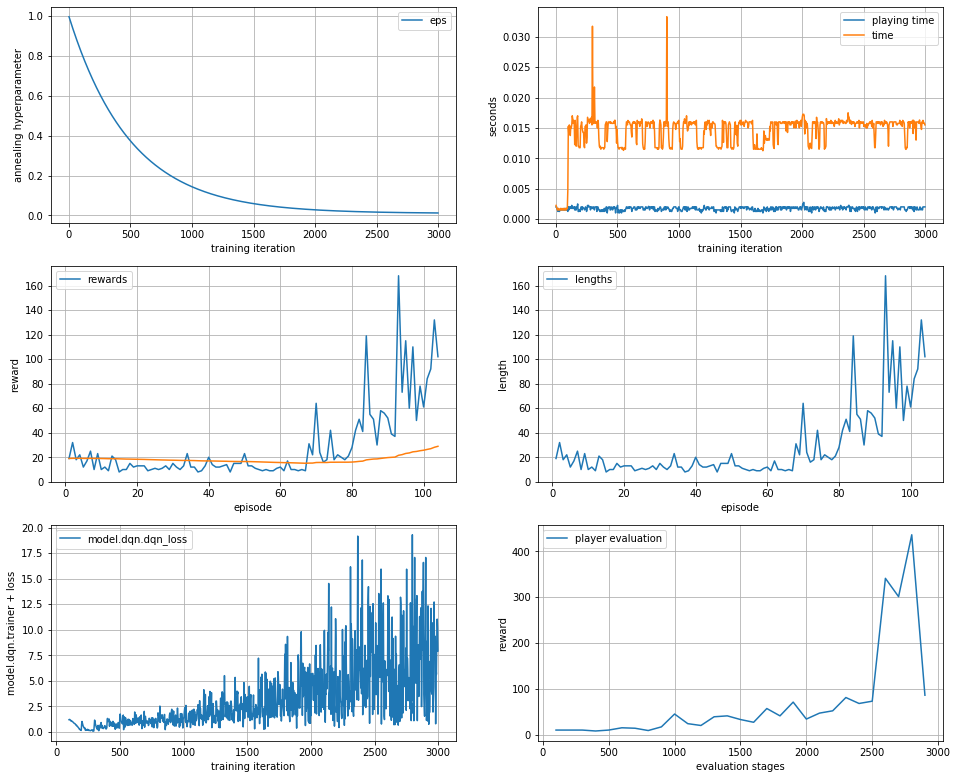

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [61]:
system.run(1000)

As reloading can cause some effects (e.g. loosing the replay buffer), *system.reload_messages* stores information about occured reloads:

In [62]:
system.reload_messages

['iteration 2000: reloaded (replay buffers are lost)']

In [63]:
# FPS (visualization and Player evaluation is not taken into account)
agent.model.runner.fps

69.53973618562866